# To Do:
- Modelle über Makro-Iteration speichern
- Modell Fine-Tuning
- Visualisierung optisch optimieren

In [1]:
# Imports

#Pandas: Reading and analyzing data
import pandas as pd
#Numerical calcuations
import numpy as np
#statistical data visualization
import seaborn as sns
#Use Dates in Datetime Format
from datetime import datetime, timedelta
#Tensorflow
import tensorflow as tf
#Keras: Open-Source deep-learning library 
from tensorflow import keras
#Building blocks of NN in Keras
from tensorflow.keras import layers
#EarlyStop to stop training early
from tensorflow.keras.callbacks import EarlyStopping
#Functional API: Layers for different models
from keras.layers import Dense, LSTM, Dropout
#Normalization
from sklearn.preprocessing import MinMaxScaler
#Standardization
from sklearn.preprocessing import StandardScaler
#Evaluate models
import math
#Evaluate MSE
from sklearn.metrics import mean_squared_error
#plot numpy array
import matplotlib.pyplot as plt
#Create Folder for modelling checkpoint
import os
#Callback to logg model fitting time
import time
from timeit import default_timer as timer
#Clear output after training
import IPython
import IPython.display
#Normalization
from sklearn.preprocessing import MinMaxScaler
#Standardization
from sklearn.preprocessing import StandardScaler
#Define input length for model
import statsmodels.api as sm

#Helper Class (Export Notebook as .py)
from windowgenerator import WindowGenerator
from global_helper_functions import *

# Data Analytics

33


<AxesSubplot: title={'center': 'KIT load profile from 2019-2021 [kW]'}, xlabel='Time', ylabel='Load [kW]'>

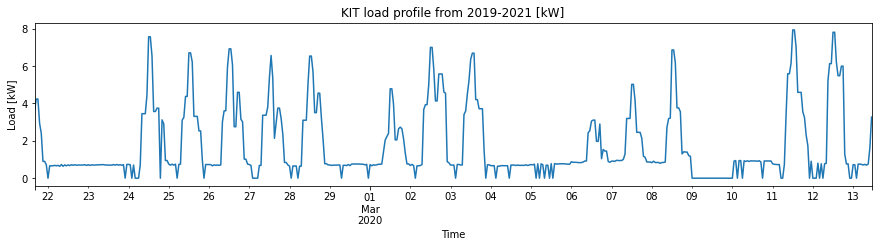

In [2]:
#Get Data

#Define Path to datafile
user = 'rs1044' #'Jonas'
filename = '00Data_KIT_2019-01-01_to_2021_12_31.csv'
path = 'C:/Users/' + user + '/bwSyncShare/02Python Code/Data/' + filename

#1.1 Data collection & Visualization

#Read CSV file to pandas dataframe; encoding= 'unicode_escape': Decode from Latin-1 source code. Default UTF-8.
df = pd.read_csv(path, encoding= 'unicode_escape', index_col='Date')
df.index = pd.to_datetime(df.index)
df_feature = df.copy()
#Drop columns with insignificant weather features
df.drop(columns=['prcp', 'wdir','pres', 'coco','dwpt', 'wpgt','wspd'], axis=1, inplace=True)
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

#List with Smart meter names
smart_meter_names = df.columns[2:-2]
print(len(smart_meter_names))

#Visualize
df['0213-ZE01-71'][10000:10500].plot(title="KIT load profile from 2019-2021 [kW]",
             figsize=(15,3), 
             xlabel="Time", 
             ylabel="Load [kW]",
             kind="line"
            )

### Feature Engineering

In [3]:
#Convert Time String to seconds
date_time = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)

#Sine cosine Scaling
hour = 60*60
df['hour sin'] = np.sin(timestamp_s * (2 * np.pi / hour))
df['hour cos'] = np.cos(timestamp_s * (2 * np.pi / hour))
df.drop('hour', axis=1, inplace=True)

daysinweek = 7*24*60*60
df['dayofweek sin'] = np.sin(timestamp_s * (2 * np.pi / daysinweek))
df['dayofweek cos'] = np.cos(timestamp_s * (2 * np.pi / daysinweek))
df.drop('dayofweek', axis=1, inplace=True)

#Min Max Sclaing
col_names = df.columns
features = df[col_names]

scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
df = pd.DataFrame(features, columns = col_names, index=df.index)
df.head(1)

,temp,rhum,0101-ZE01-70,0101-ZE01-74,0141-ZE01-70,0141-ZE01-74,0145-ZE02-70,0213-ZE01-71,0223-ZE01-71,0223-ZE02-71,...,0430-ZE01-70,0439-ZE01-70,0439-ZE01-72,0439-ZE02-70,5311-ZE01-70,6907-ZE01-74,hour sin,hour cos,dayofweek sin,dayofweek cos
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0.325866,0.963855,0.0,0.221036,0.164777,0.164777,0.055199,0.0,0.0,0.324802,...,0.0,0.0,0.0,0.286572,0.0,0.20283,0.692833,0.0,0.012536,0.38874


### Centralized Dataframe

In [4]:
time_series_data = df
time_series_data.reset_index(inplace=True)

df_final = pd.DataFrame()
for name in smart_meter_names:
    df2 = pd.DataFrame()
    df2[['Date', 'load_value', 'temp', 'rhum', 'hour sin', 'hour cos', 'dayofweek sin', 'dayofweek cos']] = time_series_data[['Date', name, 'temp', 'rhum', 'hour sin', 'hour cos', 'dayofweek sin', 'dayofweek cos']].copy()
    df2['smart_meter'] = name
    df_final = pd.concat([df_final, df2], ignore_index=True)
df_final.head(1)

,Date,load_value,temp,rhum,hour sin,hour cos,dayofweek sin,dayofweek cos,smart_meter
0,2019-01-01,0.0,0.325866,0.963855,0.692833,0.0,0.012536,0.38874,0101-ZE01-70


# Forecasting

### 1. Datasets - Training, Testing, Data windowing

In [5]:
#Datasets
#Calculate the Date equal to 70% of the Dateerange 01.01.2019-31.12.2019
last_date_train = pd.to_datetime('01.01.2019 00:00:00', format='%d.%m.%Y %H:%M:%S') + timedelta(hours=int(len(df)*0.7))
#Calculate the Date equal to 90% of the Dateerange 01.01.2019-31.12.2019
last_date_val = pd.to_datetime('01.01.2019 00:00:00', format='%d.%m.%Y %H:%M:%S') + timedelta(hours=int(len(df)*0.9))

#Split Datasets considering the dates and then droping the Dates column as only time features are considered
train_df_F7 = df_final.loc[(df_final.Date <= last_date_train), ['load_value', 'temp', 'rhum', 'hour sin', 'hour cos', 'dayofweek sin', 'dayofweek cos']]
val_df_F7 = df_final.loc[((df_final.Date > last_date_train)&(df_final.Date >= last_date_val)), ['load_value', 'temp', 'rhum', 'hour sin', 'hour cos', 'dayofweek sin', 'dayofweek cos']]
test_df_F7 = df_final.loc[(df_final.Date > last_date_val), ['load_value', 'temp', 'rhum', 'hour sin', 'hour cos', 'dayofweek sin', 'dayofweek cos']]

#Split Datasets considering the dates and then droping the Dates column as only time features are considered
train_df_F5 = df_final.loc[(df_final.Date <= last_date_train), ['load_value', 'hour sin', 'hour cos', 'dayofweek sin', 'dayofweek cos']]
val_df_F5 = df_final.loc[((df_final.Date > last_date_train)&(df_final.Date >= last_date_val)), ['load_value', 'hour sin', 'hour cos', 'dayofweek sin', 'dayofweek cos']]
test_df_F5 = df_final.loc[(df_final.Date > last_date_val), ['load_value', 'hour sin', 'hour cos', 'dayofweek sin', 'dayofweek cos']]

### 2. Metrics dictionary - All final results 

In [6]:
%%capture
"""
final_results_dict = {
    'Centralized': {
        'Model': { #LSTM, CNN, Transformer
            'Horizon': { #12,24
                'Features': { #Time (hour sin, hour cos, weekday sin, weekday cos), Time + Weather (temp, rhum)
                    'Metric': {} #MSE, RMSE, MAPE, MAE, Time
                }
            }
        }
    }
}
"""
final_results_dict = {}
final_results_dict['Centralized'] = {}
final_results_dict['Centralized']['LSTM'] = {}
final_results_dict['Centralized']['LSTM']['H12'] = {}
final_results_dict['Centralized']['LSTM']['H12']['F5'] = {}
final_results_dict['Centralized']['LSTM']['H12']['F7'] = {}
#----------------------------------------------
final_results_dict['Centralized']['LSTM']['H24'] = {}
final_results_dict['Centralized']['LSTM']['H24']['F5'] = {}
final_results_dict['Centralized']['LSTM']['H24']['F7'] = {}

final_results_dict['Centralized']['CNN'] = {}
final_results_dict['Centralized']['CNN']['H12'] = {}
final_results_dict['Centralized']['CNN']['H12']['F5'] = {}
final_results_dict['Centralized']['CNN']['H12']['F7'] = {}
#----------------------------------------------
final_results_dict['Centralized']['CNN']['H24'] = {}
final_results_dict['Centralized']['CNN']['H24']['F5'] = {}
final_results_dict['Centralized']['CNN']['H24']['F7'] = {}

final_results_dict['Centralized']['Transformer'] = {}
final_results_dict['Centralized']['Transformer']['H12'] = {}
final_results_dict['Centralized']['Transformer']['H12']['F5'] = {}
final_results_dict['Centralized']['Transformer']['H12']['F7'] = {}
#----------------------------------------------
final_results_dict['Centralized']['Transformer']['H24'] = {}
final_results_dict['Centralized']['Transformer']['H24']['F5'] = {}
final_results_dict['Centralized']['Transformer']['H24']['F7'] = {}

### 3. Hyperparameter

In [7]:
#ITERATING
OUT_STEPS = [12, 24] #Next 12 or 24 hours
NUM_FEATURES = [5, 7] # [F_T, F_TW] load_value, hour sin, hour cos, dayofweek sin, dayofweek cos + (temp, rhum)
INPUT_STEPS = 24
INPUT_SHAPE = [(INPUT_STEPS, NUM_FEATURES[0]), (INPUT_STEPS, NUM_FEATURES[1])]

#Forecasting
MAX_EPOCHS = 100

#LSTM
NUM_LSTM_LAYERS = 4
NUM_LSTM_CELLS = 32
NUM_LSTM_DENSE_LAYERS=1
NUM_LSTM_DENSE_UNITS = 32
LSTM_DROPOUT = 0.2

#CNN
CONV_WIDTH = 3
NUM_CNN_LAYERS = 4
NUM_CNN_FILTERS = 24
NUM_CNN_DENSE_LAYERS = 1
NUM_CNN_DENSE_UNITS = 32
CNN_DROPOUT = 0.2

### 4. Create 4 windos : Horizon 12, 24 and Features 5,7

All shapes are: (batch, time, features)
Window shape: (3, 48, 7) Inputs shape: (3, 24, 7) Labels shape: (3, 24, 1)
train_df shape: (607629, 7) val_df shape: (86823, 7) test_df shape: (86790, 7)


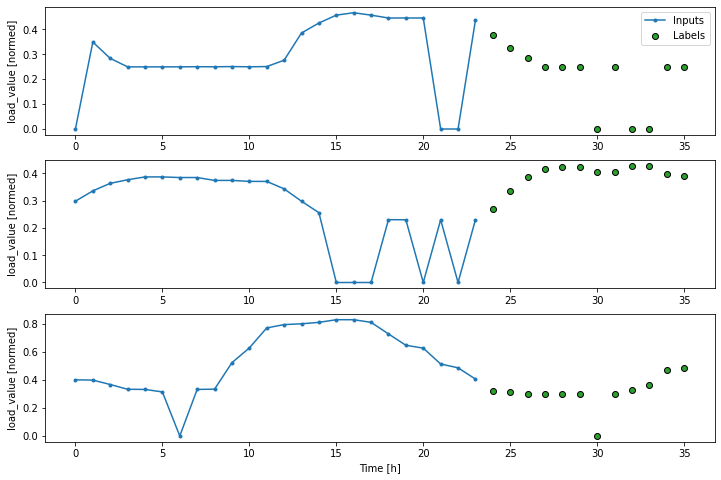

In [8]:
#window_F5_H12
window_F5_H12 = WindowGenerator(
    input_width=INPUT_STEPS, label_width=OUT_STEPS[0], shift=OUT_STEPS[0], 
    train_df = train_df_F5, val_df = val_df_F5, test_df = test_df_F5, label_columns=['load_value']
)
example_window = tf.stack([np.array(train_df_F5[10100:10100+window_F5_H12.total_window_size]),
                           np.array(train_df_F5[2000:2000+window_F5_H12.total_window_size]),
                           np.array(train_df_F5[3000:3000+window_F5_H12.total_window_size])])
example_inputs, example_labels = window_F5_H12.split_window(example_window)
window_F5_H12.example = example_inputs, example_labels

#window_F5_H24
window_F5_H24 = WindowGenerator(
    input_width=INPUT_STEPS, label_width=OUT_STEPS[1], shift=OUT_STEPS[1], 
    train_df = train_df_F5, val_df = val_df_F5, test_df = test_df_F5, label_columns=['load_value']
)
example_window = tf.stack([np.array(train_df_F5[10100:10100+window_F5_H24.total_window_size]),
                           np.array(train_df_F5[2000:2000+window_F5_H24.total_window_size]),
                           np.array(train_df_F5[3000:3000+window_F5_H24.total_window_size])])
example_inputs, example_labels = window_F5_H24.split_window(example_window)
window_F5_H24.example = example_inputs, example_labels

#window_F7_H12
window_F7_H12 = WindowGenerator(
    input_width=INPUT_STEPS, label_width=OUT_STEPS[0], shift=OUT_STEPS[0], 
    train_df = train_df_F7, val_df = val_df_F7, test_df = test_df_F7, label_columns=['load_value']
)
example_window = tf.stack([np.array(train_df_F7[10100:10100+window_F7_H12.total_window_size]),
                           np.array(train_df_F7[2000:2000+window_F7_H12.total_window_size]),
                           np.array(train_df_F7[3000:3000+window_F7_H12.total_window_size])])
example_inputs, example_labels = window_F7_H12.split_window(example_window)
window_F7_H12.example = example_inputs, example_labels

#window_F5_H24
window_F7_H24 = WindowGenerator(
    input_width=INPUT_STEPS, label_width=OUT_STEPS[1], shift=OUT_STEPS[1], 
    train_df = train_df_F7, val_df = val_df_F7, test_df = test_df_F7, label_columns=['load_value']
)
example_window = tf.stack([np.array(train_df_F7[10100:10100+window_F7_H24.total_window_size]),
                           np.array(train_df_F7[2000:2000+window_F7_H24.total_window_size]),
                           np.array(train_df_F7[3000:3000+window_F7_H24.total_window_size])])
example_inputs, example_labels = window_F7_H24.split_window(example_window)
window_F7_H24.example = example_inputs, example_labels

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}', f'Inputs shape: {example_inputs.shape}', f'Labels shape: {example_labels.shape}')
print(f'train_df shape: {train_df_F7.shape}', f'val_df shape: {val_df_F7.shape}', f'test_df shape: {test_df_F7.shape}')
window_F7_H12.plot(plot_col='load_value')

# Model Building, Fitting, Evaluation

In [9]:
tf.random.set_seed(42)

### Features 5, Horizon 12

In [10]:
#LSTM
global_lstm_F5_H12 = build_LSTM_model(
    INPUT_SHAPE[0], NUM_LSTM_CELLS, NUM_LSTM_LAYERS, NUM_LSTM_DENSE_LAYERS, 
    NUM_LSTM_DENSE_UNITS, LSTM_DROPOUT, OUT_STEPS[0], NUM_FEATURES[0], 'Global_LSTM_F5_H12'
)
final_results_dict = compile_fit_evaluate_model(global_lstm_F5_H12, window_F5_H12, 'Global_LSTM_F5_H12', 'LSTM', OUT_STEPS[0], NUM_FEATURES[0], MAX_EPOCHS,final_results_dict)

#CNN
global_cnn_F5_H12 = build_CNN_model(
    INPUT_SHAPE[0], CONV_WIDTH, NUM_CNN_LAYERS, NUM_CNN_FILTERS, NUM_CNN_DENSE_LAYERS, NUM_CNN_DENSE_UNITS,
    CNN_DROPOUT, OUT_STEPS[0], NUM_FEATURES[0], 'GLOBAL_CNN_F5_H12'
)
final_results_dict = compile_fit_evaluate_model(global_cnn_F5_H12, window_F5_H12, 'GLOBAL_CNN_F5_H12', 'CNN', OUT_STEPS[0], NUM_FEATURES[0], MAX_EPOCHS, final_results_dict)

#Transformer
global_transformer_F5_H12 = build_transformer_model(
    INPUT_SHAPE[0], OUT_STEPS[0], NUM_FEATURES[0], 'Global_Transformer_F5_H12'
)
final_results_dict = compile_fit_evaluate_model(global_transformer_F5_H12, window_F5_H12, 'Global_Transformer_F5_H12', 'Transformer', OUT_STEPS[0], NUM_FEATURES[0], MAX_EPOCHS, final_results_dict)

2712/2712 [==============================] - 13s 5ms/step - loss: 0.0398 - root_mean_squared_error: 0.1994 - mean_absolute_percentage_error: 120272656.0000 - mean_absolute_error: 0.1752
[0.03977717459201813, 0.19944214820861816, 120272656.0, 0.1752253770828247]


### Features 5, Horizon 24

In [11]:
#LSTM
global_lstm_F5_H24 = build_LSTM_model(
    INPUT_SHAPE[0], NUM_LSTM_CELLS, NUM_LSTM_LAYERS, NUM_LSTM_DENSE_LAYERS, 
    NUM_LSTM_DENSE_UNITS, LSTM_DROPOUT, OUT_STEPS[1], NUM_FEATURES[0], 'Global_LSTM_F5_H24'
)
#Compile, Fit, Evaluate
final_results_dict = compile_fit_evaluate_model(global_lstm_F5_H24, window_F5_H24, 'Global_LSTM_F5_H24', 'LSTM', OUT_STEPS[1], NUM_FEATURES[0], MAX_EPOCHS, final_results_dict) 

#CNN
global_cnn_F5_H24 = build_CNN_model(
    INPUT_SHAPE[0], CONV_WIDTH, NUM_CNN_LAYERS, NUM_CNN_FILTERS, NUM_CNN_DENSE_LAYERS, NUM_CNN_DENSE_UNITS,
    CNN_DROPOUT, OUT_STEPS[1], NUM_FEATURES[0], 'GLOBAL_CNN_F5_H24'
)
final_results_dict = compile_fit_evaluate_model(global_cnn_F5_H24, window_F5_H24, 'GLOBAL_CNN_F5_H24', 'CNN', OUT_STEPS[1], NUM_FEATURES[0], MAX_EPOCHS, final_results_dict)

#Transformer
global_transformer_F5_H24 = build_transformer_model(
    INPUT_SHAPE[0], OUT_STEPS[1], NUM_FEATURES[0], 'Global_Transformer_F5_H24'
)
final_results_dict = compile_fit_evaluate_model(global_transformer_F5_H24, window_F5_H24, 'Global_Transformer_F5_H24', 'Transformer', OUT_STEPS[1], NUM_FEATURES[0], MAX_EPOCHS, final_results_dict)

2711/2711 [==============================] - 12s 5ms/step - loss: 0.0375 - root_mean_squared_error: 0.1936 - mean_absolute_percentage_error: 103815928.0000 - mean_absolute_error: 0.1662
[0.03748728707432747, 0.1936163306236267, 103815928.0, 0.1662476509809494]


### Features 7, Horizon 12

In [12]:
#LSTM
global_lstm_F7_H12 = build_LSTM_model(
    INPUT_SHAPE[1], NUM_LSTM_CELLS, NUM_LSTM_LAYERS, NUM_LSTM_DENSE_LAYERS, 
    NUM_LSTM_DENSE_UNITS, LSTM_DROPOUT, OUT_STEPS[0], NUM_FEATURES[1], 'Global_LSTM_F7_H12'
)
final_results_dict = compile_fit_evaluate_model(global_lstm_F7_H12, window_F7_H12, 'Global_LSTM_F7_H12', 'LSTM', OUT_STEPS[0], NUM_FEATURES[1], MAX_EPOCHS, final_results_dict) 

#CNN
global_cnn_F7_H12 = build_CNN_model(
    INPUT_SHAPE[1], CONV_WIDTH, NUM_CNN_LAYERS, NUM_CNN_FILTERS, NUM_CNN_DENSE_LAYERS, NUM_CNN_DENSE_UNITS,
    CNN_DROPOUT, OUT_STEPS[0], NUM_FEATURES[1], 'GLOBAL_CNN_F7_H12'
)
final_results_dict = compile_fit_evaluate_model(global_cnn_F7_H12, window_F7_H12, 'GLOBAL_CNN_F7_H12', 'CNN', OUT_STEPS[0], NUM_FEATURES[1], MAX_EPOCHS, final_results_dict)

#Transformer
global_transformer_F7_H12 = build_transformer_model(
    INPUT_SHAPE[1], OUT_STEPS[0], NUM_FEATURES[1], 'Global_Transformer_F7_H12'
)
final_results_dict = compile_fit_evaluate_model(global_transformer_F7_H12, window_F7_H12, 'Global_Transformer_F7_H12', 'Transformer', OUT_STEPS[0], NUM_FEATURES[1], MAX_EPOCHS, final_results_dict)

2712/2712 [==============================] - 19s 7ms/step - loss: 0.0377 - root_mean_squared_error: 0.1943 - mean_absolute_percentage_error: 108008824.0000 - mean_absolute_error: 0.1632
[0.03773575648665428, 0.19425685703754425, 108008824.0, 0.16322959959506989]


### Features 7, Horizon 24

In [13]:
global_lstm_F7_H24 = build_LSTM_model(
    INPUT_SHAPE[1], NUM_LSTM_CELLS, NUM_LSTM_LAYERS, NUM_LSTM_DENSE_LAYERS, 
    NUM_LSTM_DENSE_UNITS, LSTM_DROPOUT, OUT_STEPS[1], NUM_FEATURES[1], 'Global_LSTM_F7_H24'
)
final_results_dict = compile_fit_evaluate_model(global_lstm_F7_H24, window_F7_H24, 'Global_LSTM_F7_H24', 'LSTM', OUT_STEPS[1], NUM_FEATURES[1], MAX_EPOCHS, final_results_dict) 

#CNN
global_cnn_F7_H24 = build_CNN_model(
    INPUT_SHAPE[1], CONV_WIDTH, NUM_CNN_LAYERS, NUM_CNN_FILTERS, NUM_CNN_DENSE_LAYERS, NUM_CNN_DENSE_UNITS,
    CNN_DROPOUT, OUT_STEPS[1], NUM_FEATURES[1], 'GLOBAL_CNN_F7_H24'
)
final_results_dict = compile_fit_evaluate_model(global_cnn_F7_H24, window_F7_H24, 'GLOBAL_CNN_F7_H24', 'CNN', OUT_STEPS[1], NUM_FEATURES[1], MAX_EPOCHS, final_results_dict)

#Transformer
global_transformer_F7_H24 = build_transformer_model(
    INPUT_SHAPE[1], OUT_STEPS[1], NUM_FEATURES[1], 'Global_Transformer_F7_H24'
)
final_results_dict = compile_fit_evaluate_model(global_transformer_F7_H24, window_F7_H24, 'Global_Transformer_F7_H24', 'Transformer', OUT_STEPS[1], NUM_FEATURES[1], MAX_EPOCHS, final_results_dict)

2711/2711 [==============================] - 23s 9ms/step - loss: 0.0398 - root_mean_squared_error: 0.1996 - mean_absolute_percentage_error: 115049096.0000 - mean_absolute_error: 0.1769
[0.03983651101589203, 0.19959086179733276, 115049096.0, 0.17690858244895935]


# Evaluation

In [14]:
final_results_dict

{'Centralized': {'LSTM': {'H12': {'F5': {'MSE': 0.07493498921394348,
     'RMSE': 0.27374255657196045,
     'MAPE': 196257104.0,
     'MAE': 0.2538009285926819,
     'Time': 70.0373338833336},
    'F7': {'MSE': 0.09417982399463654,
     'RMSE': 0.3068881928920746,
     'MAPE': 228073568.0,
     'MAE': 0.2811110317707062,
     'Time': 74.8702894500002}},
   'H24': {'F5': {'MSE': 0.09448736906051636,
     'RMSE': 0.30738773941993713,
     'MAPE': 228533904.0,
     'MAE': 0.2815394103527069,
     'Time': 89.7804149333333},
    'F7': {'MSE': 0.07813137024641037,
     'RMSE': 0.27951955795288086,
     'MAPE': 202190896.0,
     'MAE': 0.2585645616054535,
     'Time': 169.84191781666595}}},
  'CNN': {'H12': {'F5': {'MSE': 0.07875758409500122,
     'RMSE': 0.2806377410888672,
     'MAPE': 195631328.0,
     'MAE': 0.2586582899093628,
     'Time': 4.545169685714167},
    'F7': {'MSE': 0.09207086265087128,
     'RMSE': 0.3034318685531616,
     'MAPE': 220443616.0,
     'MAE': 0.27646923065185547,

In [15]:
import pickle 
with open('Dictionaries_Results/Centralized_results.pkl', 'wb') as f:
    pickle.dump(final_results_dict, f)

In [16]:
with open('Dictionaries_Results/Centralized_results.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
loaded_dict

{'Centralized': {'LSTM': {'H12': {'F5': {'MSE': 0.07493498921394348,
     'RMSE': 0.27374255657196045,
     'MAPE': 196257104.0,
     'MAE': 0.2538009285926819,
     'Time': 70.0373338833336},
    'F7': {'MSE': 0.09417982399463654,
     'RMSE': 0.3068881928920746,
     'MAPE': 228073568.0,
     'MAE': 0.2811110317707062,
     'Time': 74.8702894500002}},
   'H24': {'F5': {'MSE': 0.09448736906051636,
     'RMSE': 0.30738773941993713,
     'MAPE': 228533904.0,
     'MAE': 0.2815394103527069,
     'Time': 89.7804149333333},
    'F7': {'MSE': 0.07813137024641037,
     'RMSE': 0.27951955795288086,
     'MAPE': 202190896.0,
     'MAE': 0.2585645616054535,
     'Time': 169.84191781666595}}},
  'CNN': {'H12': {'F5': {'MSE': 0.07875758409500122,
     'RMSE': 0.2806377410888672,
     'MAPE': 195631328.0,
     'MAE': 0.2586582899093628,
     'Time': 4.545169685714167},
    'F7': {'MSE': 0.09207086265087128,
     'RMSE': 0.3034318685531616,
     'MAPE': 220443616.0,
     'MAE': 0.27646923065185547,